# **Exploratory Data Analysis (EDA) on Travel Bookings**

This notebook provides an in-depth analysis of travel booking trends, highlighting sales performance across years, destinations, and months, as well as identifying key areas for improvement. The analysis includes:
- **Yearly Sales Trends**
- **Destination-wise Revenue and Profit Margins**
- **Seasonal Booking Trends**
- **Cancellation Patterns**
- **Booking Window Analysis**
Our goal is to derive actionable insights that can help optimize sales and improve customer retention.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [9]:
# Load Data
file_path = "Dataset - 3.csv"
data = pd.read_csv(file_path)

# Create SQLite in-memory database
conn = sqlite3.connect(":memory:")
data.to_sql("bookings", conn, index=False, if_exists="replace")

# Display the first few rows
data.head()

,agent_id,supplier_id,Destination,Booking date,pax,booking_status,travel_date,coupon_redeem,Coupon Used?,costprice,markup,selling_price
0,4003,520,Dubai,2024-03-08,10,Confirmed,2024-03-27,1000,Yes,291137.688731,9078.398119,299216.086849
1,4711,292,Dubai,2024-07-16,1,Confirmed,2024-08-03,500,Yes,31399.560211,14033.499875,44933.060085
2,3037,864,Dubai,2024-07-16,9,Confirmed,2024-07-27,0,No,295263.854967,87840.292690,383104.147657
3,1609,430,Bali,2024-03-22,8,Confirmed,2024-04-02,0,No,326273.581726,9186.513831,335460.095557
4,3364,614,Kerala,2024-05-03,1,Confirmed,2024-07-23,2000,Yes,18327.862098,4574.085301,20901.947399


In [10]:
# Convert dates to datetime format
data['Booking date'] = pd.to_datetime(data['Booking date'], format='%Y-%m-%d', errors='coerce')
data['travel_date'] = pd.to_datetime(data['travel_date'], format='%Y-%m-%d', errors='coerce')

# Compute number of days between travel date and booking date
data['date_diff'] = (data['travel_date'] - data['Booking date']).dt.days

# Extract month and year
data['month'] = data['Booking date'].dt.month
data['year'] = data['Booking date'].dt.year
data['month_name'] = data['Booking date'].dt.strftime('%b')

In [11]:
# Update the SQL database
data.to_sql("bookings", conn, index=False, if_exists="replace")

# Display updated data types
data.dtypes

agent_id                   int64
supplier_id                int64
Destination               object
Booking date      datetime64[ns]
pax                        int64
booking_status            object
travel_date       datetime64[ns]
coupon_redeem              int64
Coupon Used?              object
costprice                float64
markup                   float64
selling_price            float64
date_diff                  int64
month                      int32
year                       int32
month_name                object
dtype: object

In [12]:
# Yearly Sales Analysis
yearly_sales = pd.read_sql("SELECT year, SUM(selling_price) AS total_sales FROM bookings GROUP BY year", conn)

yearly_sales

,year,total_sales
0,2024,5.276116e+09


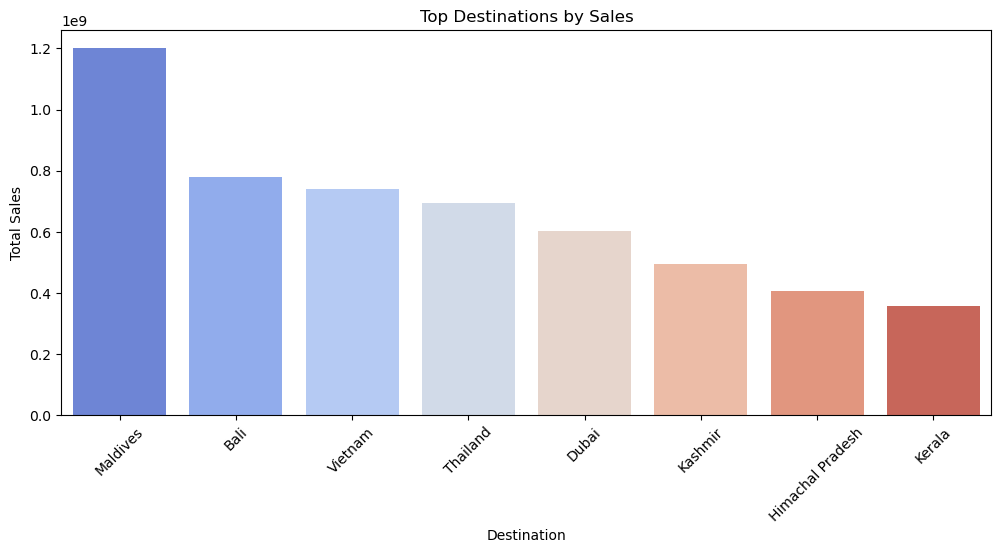

,Destination,total_sales,total_markup,margin_percent
0,Maldives,1.200223e+09,2.192993e+08,18.27
1,Bali,7.782382e+08,1.417338e+08,18.21
2,Vietnam,7.400733e+08,1.331076e+08,17.99
3,Thailand,6.950028e+08,1.256388e+08,18.08
4,Dubai,6.025770e+08,1.125329e+08,18.68
5,Kashmir,4.957916e+08,9.083262e+07,18.32
6,Himachal Pradesh,4.067667e+08,7.610684e+07,18.71
7,Kerala,3.574425e+08,6.605678e+07,18.48


In [4]:
# Destination-wise Sales and Margin Analysis
destination_analysis = pd.read_sql("""
    SELECT Destination, SUM(selling_price) AS total_sales, SUM(markup) AS total_markup, 
           ROUND((SUM(markup) / SUM(selling_price)) * 100, 2) AS margin_percent
    FROM bookings
    GROUP BY Destination
    ORDER BY total_sales DESC
""", conn)

# Visualization
plt.figure(figsize=(12,5))
sns.barplot(x=destination_analysis['Destination'], y=destination_analysis['total_sales'], palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel('Destination')
plt.ylabel('Total Sales')
plt.title('Top Destinations by Sales')
plt.show()

destination_analysis

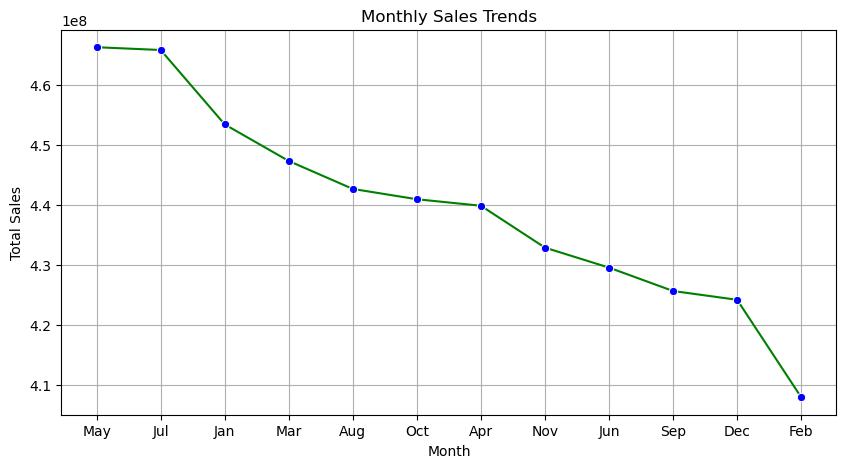

,month_name,total_sales,total_markup,margin_percent
0,May,4.662715e+08,8.768313e+07,18.81
1,Jul,4.658073e+08,8.489520e+07,18.23
2,Jan,4.533934e+08,8.307192e+07,18.32
3,Mar,4.472929e+08,8.178907e+07,18.29
4,Aug,4.426317e+08,8.144747e+07,18.40
5,Oct,4.409133e+08,8.086663e+07,18.34
6,Apr,4.398254e+08,8.139089e+07,18.51
7,Nov,4.328402e+08,7.983332e+07,18.44
8,Jun,4.295075e+08,7.795471e+07,18.15
9,Sep,4.256061e+08,7.631550e+07,17.93


In [5]:
# Monthly Revenue Trends
monthly_sales = pd.read_sql("""
    SELECT month_name, SUM(selling_price) AS total_sales, SUM(markup) AS total_markup,
           ROUND((SUM(markup) / SUM(selling_price)) * 100, 2) AS margin_percent
    FROM bookings
    GROUP BY month_name
    ORDER BY total_sales DESC
""", conn)

# Visualization
plt.figure(figsize=(10,5))
sns.lineplot(x=monthly_sales['month_name'], y=monthly_sales['total_sales'], marker='o', color='green', markerfacecolor='blue')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trends')
plt.grid(True)
plt.show()

monthly_sales

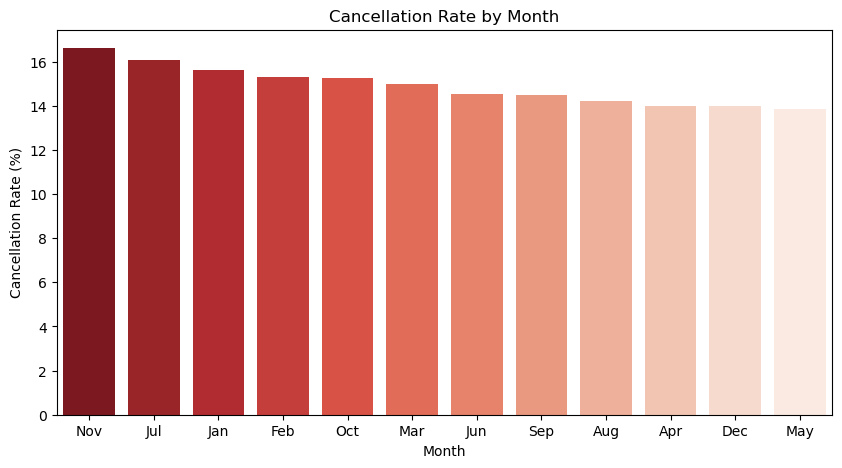

,month_name,cancellation_percent
0,Nov,16.62
1,Jul,16.06
2,Jan,15.62
3,Feb,15.33
4,Oct,15.26
5,Mar,15.01
6,Jun,14.56
7,Sep,14.48
8,Aug,14.21
9,Apr,14.01


In [6]:
# Cancellation Rate Analysis
cancellation_rate = pd.read_sql("""
    SELECT month_name, 
           ROUND((SUM(CASE WHEN booking_status='Canceled' THEN 1 ELSE 0 END) * 100.0) / COUNT(*), 2) AS cancellation_percent
    FROM bookings
    GROUP BY month_name
    ORDER BY cancellation_percent DESC
""", conn)

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(x=cancellation_rate['month_name'], y=cancellation_rate['cancellation_percent'], palette='Reds_r')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by Month')
plt.show()

cancellation_rate

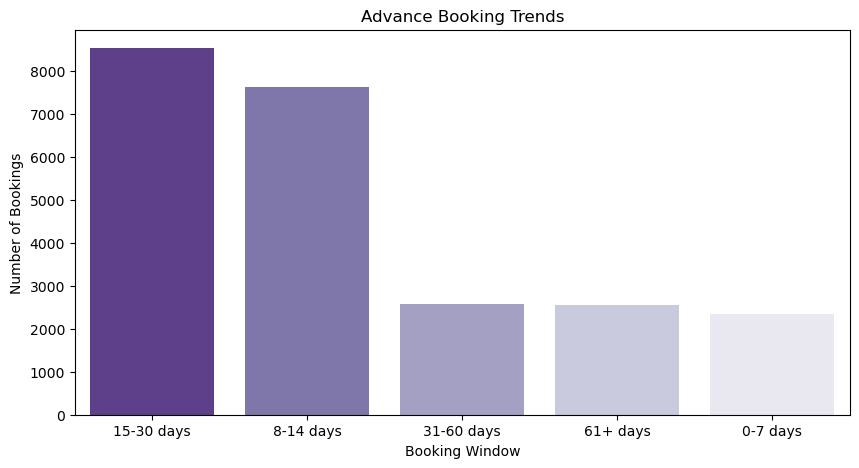

,booking_window,booking_count,percentage
0,15-30 days,8535,36.08
1,8-14 days,7637,32.28
2,31-60 days,2572,10.87
3,61+ days,2563,10.83
4,0-7 days,2350,9.93


In [7]:
# Booking Window Analysis
bins = [0, 7, 14, 30, 60, 365]
labels = ['0-7 days', '8-14 days', '15-30 days', '31-60 days', '61+ days']
data['booking_window'] = pd.cut(data['date_diff'], bins=bins, labels=labels)

# Update the SQL database
data.to_sql("bookings", conn, index=False, if_exists="replace")

# Booking window distribution
booking_window_analysis = pd.read_sql("""
    SELECT booking_window, COUNT(*) AS booking_count,
           ROUND((COUNT(*) * 100.0) / (SELECT COUNT(*) FROM bookings), 2) AS percentage
    FROM bookings
    GROUP BY booking_window
    ORDER BY booking_count DESC
""", conn)

# Visualization
plt.figure(figsize=(10,5))
sns.barplot(x=booking_window_analysis['booking_window'], y=booking_window_analysis['booking_count'], palette='Purples_r')
plt.xlabel('Booking Window')
plt.ylabel('Number of Bookings')
plt.title('Advance Booking Trends')
plt.show()

booking_window_analysis

## **Key Takeaways and Recommendations**

- **Peak sales months:** Certain months generate higher sales. Consider running promotions in slower months to balance revenue.
- **Top destinations:** Some locations generate higher revenue and profit. Focus marketing efforts on these destinations.
- **Cancellation trends:** Identify months with high cancellations and offer flexible policies or incentives to reduce them.
- **Booking window insights:** The majority of bookings occur within **15-30 days before travel**. Encourage early bookings with discounts.

**Suggestions:**
1. Optimize pricing strategies for high-margin destinations.
2. Develop early booking incentives to shift bookings to a longer window.
3. Target peak cancellation months with improved refund policies.

By implementing these strategies, travel businesses can maximize revenue while improving customer satisfaction.